<a href="https://colab.research.google.com/github/nikhithatemburu/IIIT-FMML-ASSIGNMENT/blob/main/FMML_Module_9_Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 9: Convolutional Neural Networks
## **Lab 4**
### Module coordinator: Kushagra Agarwal

<img src="https://miro.medium.com/max/1200/1*QoqNAg2t6lF8Q6WWA6AbOg.png" width=650px/>

## Using learnt representations
In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.


We'll train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.




In [1]:
# Import packages
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import time
import os

In [2]:
# Device configuration (whether to run on GPU or CPU)
device = 'cpu' #torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Download and extract dataset
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip -q hymenoptera_data.zip

--2024-05-11 16:29:04--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.225.4.72, 13.225.4.109, 13.225.4.25, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.225.4.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  78.8MB/s    in 0.6s    

2024-05-11 16:29:06 (78.8 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data_dir = './hymenoptera_data'
train_dataset = ImageFolder(os.path.join(data_dir, 'train'), train_transform)
val_dataset = ImageFolder(os.path.join(data_dir, 'val'), val_transform)
train_dataloader = DataLoader(train_dataset, batch_size=4,shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=4,shuffle=True, num_workers=2)
class_names = train_dataset.classes


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


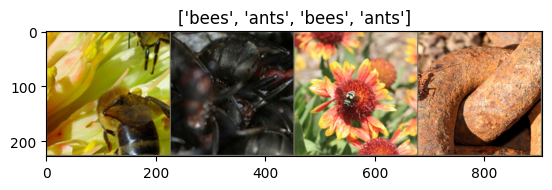

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(model, train_dataloader, criterion, optimizer, num_epochs=25):

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, labels)

              # backward + optimize only if in training phase
              loss.backward()
              optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataloader.dataset)
        epoch_acc = running_corrects.double() / len(train_dataloader.dataset)

        print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        print()

In [7]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
from torchvision import models

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

loss_func = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 107MB/s]


In [9]:
num_epochs = 5
train_model(model_ft, train_dataloader, loss_func, optimizer, num_epochs)

Epoch 0/4
----------
Loss: 0.6992 Acc: 0.6721

Epoch 1/4
----------
Loss: 0.6895 Acc: 0.7213

Epoch 2/4
----------
Loss: 0.4981 Acc: 0.7869

Epoch 3/4
----------
Loss: 0.4374 Acc: 0.8238

Epoch 4/4
----------
Loss: 0.5871 Acc: 0.7869



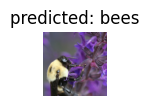

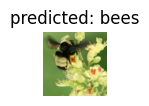

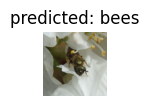

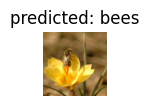

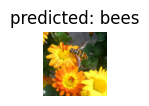

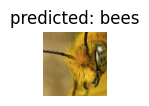

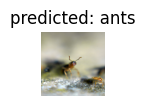

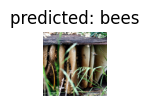

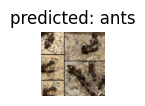

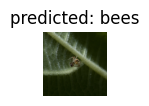

In [10]:
visualize_model(model_ft)

## Example of How Pretrained models are used for Target Tasks

<img src="https://www.researchgate.net/publication/340225334/figure/fig2/AS:960014822944773@1605896778155/Mechanism-of-transfer-learning-using-pre-trained-models.png" width=950px/>

## Questions:
1) What is the significance of using data augmentations like resize, crop etc on training data?

2) What performance do you get if you don't use pretrained resnet model (Hint: Change pretrained=False and train the model)

3) If the resnet model was pre-trained on dataset significantly different than the ants vs bees data, would you still get good performance by using this pretrained model?


# Answer For Question 1

Data augmentation techniques like resizing, cropping, flipping, rotating, and adjusting brightness or contrast are crucial in training machine learning models, especially in computer vision tasks. Here's why they're significant:

Increased Robustness: Augmentations help in making the model more robust by exposing it to a variety of transformations that mimic real-world scenarios. For example, in object recognition tasks, objects might appear in different sizes, angles, or lighting conditions. By training the model with augmented data, it learns to be invariant to these variations.

Regularization: Augmentations act as a form of regularization by effectively increasing the size of the training dataset. This helps in preventing overfitting by reducing the model's reliance on specific features or patterns present only in the original data.

Generalization: Data augmentation encourages the model to learn more generalizable features rather than memorizing specific training examples. It helps the model to understand the underlying concepts of the data rather than memorizing specific instances.

Data Diversity: Augmentations increase the diversity of the training data, which is especially important when dealing with limited datasets. They ensure that the model encounters a wide range of variations in the input data during training, leading to better generalization performance.

Avoiding Biases: Augmentations can help mitigate biases present in the original dataset. For example, if the training data predominantly contains images of certain orientations or lighting conditions, augmentations can introduce variations to balance out these biases.

Improved Performance: When deployed in conjunction with techniques like transfer learning, data augmentation can significantly improve the performance of models, especially in scenarios where labeled data is scarce.

# Answer For Question 2

If you don't use a pre-trained ResNet model and train it from scratch on your dataset, the performance may not be as good as when using a pre-trained model. Here's why:

Feature Learning: Pre-trained models, such as those available in popular deep learning frameworks like PyTorch and TensorFlow, are typically trained on large-scale datasets like ImageNet. During this pre-training phase, the model learns rich and meaningful representations of images, which can be transferred to new tasks with relatively small datasets. Training from scratch on your dataset means that the model has to learn these representations from scratch, which may require a much larger dataset and computational resources.

Generalization: Pre-trained models have already learned to generalize well to a wide range of images due to their training on diverse datasets. Training from scratch may lead to overfitting on your dataset, especially if it is small or lacks diversity.

Training Time: Training a deep neural network from scratch can be computationally expensive and time-consuming, especially for large models like ResNet with many parameters. In contrast, fine-tuning a pre-trained model typically requires fewer training iterations and less time.

Performance: Without the benefit of pre-trained weights, the model may converge to a suboptimal solution or fail to learn useful features from the data. This can result in lower performance on your task compared to using a pre-trained model.

# Answer For Question 3

Using a pre-trained ResNet model on a dataset significantly different from the ants vs. bees dataset may still yield reasonable performance, but it might not be as good as if the pre-training dataset were more similar. Here's why:

Transferability of Features: Pre-trained models learn to extract generic features from images that are useful for a wide range of tasks. While these features can generalize to some extent across different datasets, they might not capture all the relevant characteristics specific to the ants vs. bees dataset. As a result, some fine-tuning or adaptation of the pre-trained model may be necessary to achieve optimal performance.

Domain Shift: If the pre-training dataset is significantly different from the ants vs. bees dataset in terms of content, style, or distribution, there may be a domain shift. In this case, directly using the pre-trained model without any adaptation may lead to suboptimal performance because the learned features may not align well with the characteristics of the new dataset.

Overfitting: Using a pre-trained model on a significantly different dataset may increase the risk of overfitting, especially if the new dataset is relatively small. The model may already be biased towards certain features present in the pre-training data, which may not be relevant or informative for the ants vs. bees dataset.

Fine-tuning and Adaptation: To address these challenges, fine-tuning the pre-trained model on the new dataset or using techniques like domain adaptation may be necessary. This involves updating the weights of the pre-trained model using the new dataset while preventing overfitting and preserving the valuable knowledge learned during pre-training.